# Learned Replica Exchange (LREX)

Using alanine dipeptide and alanine tetrapeptide as examples.

See also https://github.com/invemichele/learned-replica-exchange

Paper available at [JPCL](https://pubs.acs.org/doi/10.1021/acs.jpclett.2c03327) or [arXiv](https://arxiv.org/abs/2210.14104)

## Setup the environment


In [ ]:
%%time

##install conda https://towardsdatascience.com/conda-google-colab-75f7c867a522
import sys
latest_conda = '4.12.0' #check here https://docs.conda.io/en/latest/miniconda.html
conda_sh = f'Miniconda3-py{sys.version_info[0]}{sys.version_info[1]}_{latest_conda}-Linux-x86_64.sh'
print('using this conda:', conda_sh)
!wget -qnc https://repo.anaconda.com/miniconda/{conda_sh}
%env PYTHONPATH=
!bash {conda_sh} -bfp /usr/local
sys.path.append(f'/usr/local/lib/python{sys.version_info[0]}.{sys.version_info[1]}/site-packages')

##install openmm
!conda install -yc conda-forge openmm

##install plumed (used for reference simulations, not here)
# !conda install -yc conda-forge plumed py-plumed openmm-plumed

##install bgflow, bgmol and dependencies
!pip install einops mdtraj git+https://github.com/bayesiains/nflows git+https://github.com/noegroup/bgflow git+https://github.com/noegroup/bgmol

##all the other needed packages, such as torch and matplotlib, should already be preinstalled

using this conda: Miniconda3-py38_4.12.0-Linux-x86_64.sh
env: PYTHONPATH=
PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py38h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py38h06a4308_2
    - cffi==1.15.0=py38hd667e15_1
    - charset-normalizer==2.0.4=pyhd3eb1b0_0
    - colorama==0.4.4=pyhd3eb1b0_0
    - conda-content-trust==0.1.1=pyhd3eb1b0_0
    - conda-package-handling==1.8.1=py38h7f8727e_0
    - conda==4.12.0=py38h06a4308_0
    - cryptography==36.0.0=py38h9ce1e76_0
    - idna==3.3=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4cf53a_17
    - ncurses==6.3=h7f8727e_2
    - openssl==1.1.1n=h7f8727e_0
    

CPU times: user 6.33 s, sys: 1.02 s, total: 7.35 s
Wall time: 6min 52s


## Define the system and useful functions

In [ ]:
import numpy as np
import mdtraj as md

import matplotlib.pyplot as plt
from IPython.display import clear_output #Colab seems to handle clear_output and '\r' in a slightly different way, I had to remove some output

In [ ]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [ ]:
import torch
import bgmol
import bgflow as bg
from bgflow.utils.types import assert_numpy

#define context
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ctx = {"device": device, "dtype": torch.float32}
ctx

{'device': device(type='cuda', index=0), 'dtype': torch.float32}

In [ ]:
#shortcut function for the model system
def get_model(system_name, temperature=None):
    
    model = bgmol.system_by_name(system_name.replace('ModifiedPSI', ''))
    
    if 'ModifiedPSI' in system_name:
        extraBias_str = '100*sin(0.5*theta)^2'
        extraBias = openmm.CustomTorsionForce(extraBias_str)
        psi_angles = md.compute_psi(md.Trajectory(model.positions, model.mdtraj_topology))[0]
        for i in range(len(psi_angles)):
            extraBias.addTorsion(*psi_angles[i])
            print(f"{system_name}, adding bias on psi{psi_angles[i]}: {extraBias_str}")
        model.system.addForce(extraBias)        
    
    if temperature is not None:
        model.reinitialize_energy_model(temperature=temperature)
    
    return model

In [ ]:
#setup the system
T_low = 300
T_high = 1000

system_name = 'AlanineDipeptide'
prior_name = target_name = system_name + 'Vacuum'

# system_name = 'AlanineTetrapeptide'
# prior_name = system_name + 'VacuumModifiedPSI'
# target_name = system_name + 'Implicit'

CLIPPING = 100

model = get_model(prior_name)

#define prior and target
prior = get_model(prior_name, T_high)
target = get_model(target_name, T_low)

if CLIPPING:
    grad_clipping = bg.utils.ClipGradient(clip=CLIPPING, norm_dim=3)
    target = bg.GradientClippedEnergy(target.energy_model, grad_clipping).to(**ctx)
    print('clipping atom forces at', CLIPPING)    

model.positions.shape

/usr/local/lib/python3.8/site-packages/bgflow/distribution/energy/openmm.py:200: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


clipping atom forces at 100


(22, 3)

In [ ]:
#some useful things
#prior-target free energy difference estimates from OPES 
DF = 0
if system_name == 'AlanineDipeptide':
    if prior_name == target_name == system_name + 'Vacuum' and (T_high, T_low) == (1000, 300):
        DF = -4.0
    elif prior_name == target_name == system_name + 'Implicit' and (T_high, T_low) == (1000, 300):
        DF = -19.2
    elif prior_name == target_name == system_name + 'Implicit' and (T_high, T_low) == (1000, 100):
        DF = -129.4
elif system_name == 'AlanineTetrapeptide':
    if prior_name == target_name == system_name + 'Implicit' and (T_high, T_low) == (1000, 300):
        DF = 28.4
    elif prior_name == target_name == system_name + 'Implicit' and (T_high, T_low) == (1000, 100):
        DF = -12.4

#define a custom dataset
class highTempDataset(torch.utils.data.Dataset):
    """
    Simple wrapper for the trajectory at high temperature
    """
    def __init__(self, data, energies):
        assert len(data) == len(energies)
        self.data = data
        self.energies = energies
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.energies[idx]

#define trainer
def train_loop(dataloader, loss_fn, optimizer, reporter, scheduler=None):
    size = len(dataloader.dataset)
    for batch, (z, ene) in enumerate(dataloader):
        # Compute prediction and loss
        loss = loss_fn(z, ene)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        if (batch + 1) % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(z)
            reporter.append(loss)
            # print(f"loss: {loss:g}  [{current:>5d}/{size:>5d}]     ", end='\r')
    if scheduler is not None:
        scheduler.step()

In [ ]:
#some plotting functions
from matplotlib.colors import LogNorm

def get_phi_psi(trajectory, i=-1, model=model):
    if not isinstance(trajectory, md.Trajectory):
        if isinstance(trajectory, torch.Tensor):
            trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
        trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
    phi = md.compute_phi(trajectory)[1][:,i]
    psi = md.compute_psi(trajectory)[1][:,i]
    return phi, psi

def plot_rama_traj(trajectory, w=None, get_phi=False, i=-1, model=model):
    phi, psi = get_phi_psi(trajectory, i)
    plot_range = [-np.pi, np.pi]
    
    #histogram
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title("Histogram")
    plt.hist2d(phi, psi, 60, weights=w, norm=LogNorm(), range=[plot_range,plot_range])
    plt.xlim(plot_range)
    plt.ylim(plot_range)
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.gca().set_aspect(1)
    
    #trajectory
    plt.subplot(1,2,2)
    plt.title("Trajectory")
    end = len(phi)
    plt.scatter(range(end), phi, c=psi, s=10)
    plt.xlim([0, end])
    plt.xlabel("Time [ps]")
    plt.ylabel("$\phi$")
    # plt.gca().set_box_aspect(0.5)
    plt.show()
    
    if get_phi:
        return phi

def plot_phi_FES(phi, w=None, n_bins='auto', T_high=T_high, T_low=T_low, ymax=20):
    import os.path
    ref_path = 'https://raw.githubusercontent.com/invemichele/learned-replica-exchange/main/FESreference/'
    plot_range = (-np.pi, np.pi)
    hist, edges = np.histogram(phi, bins=n_bins, range=plot_range)
    fes_estimate = -np.log(np.where(hist!=0,hist/hist.max(),np.nan))
    plt.plot(edges[:-1]+(edges[1]-edges[0])/2, fes_estimate, label="direct FES")
    DeltaF_T_high = None
    DeltaF_T_low = None
    try:
        ref_file = f'FES-{prior_name}-T{T_high}.dat'
        if not os.path.isfile(ref_file):
            !wget {ref_path}{ref_file}
        phi_ref, fes_ref = np.loadtxt(ref_file, usecols=(0,1), unpack=True)
        fes_ref /= (kB*T_high)
        plt.plot(phi_ref, fes_ref, label=f"reference {T_high}K", linestyle='dotted')
        ymax = max(ymax, np.amax(fes_ref))
        DeltaF_T_high = np.logaddexp.reduce(-fes_ref[phi_ref<0])-np.logaddexp.reduce(-fes_ref[phi_ref>0])
    except IOError:
        print('+++ Ref. file not found: '+ref_file+' +++')
    if w is not None:
        if n_bins == 'auto':
            n_bins = 50
        hist, edges =np.histogram(phi, bins=n_bins, range=plot_range, weights=w)
        fes_estimate = -np.log(np.where(hist!=0,hist/hist.max(),np.nan))
        plt.plot(edges[:-1]+(edges[1]-edges[0])/2, fes_estimate, label="reweighted FES")
        try:
            ref_file = f'FES-{target_name}-T{T_low}.dat'
            if not os.path.isfile(ref_file):
                !wget {ref_path}{ref_file}
            phi_ref, fes_ref = np.loadtxt(ref_file, usecols=(0,1), unpack=True)
            fes_ref /= (kB*T_low)
            plt.plot(phi_ref, fes_ref, label=f"reference {T_low}K", linestyle='dotted')
            ymax = max(ymax, np.amax(fes_ref))
            DeltaF_T_low = np.logaddexp.reduce(-fes_ref[phi_ref<0])-np.logaddexp.reduce(-fes_ref[phi_ref>0])
        except IOError:
            print('+++ Ref. file not found: '+ref_file+' +++')
    plt.xlim(plot_range)
    plt.ylim(bottom=0, top=min(ymax, max(fes_estimate)))
    plt.xlabel("$\phi$")
    plt.ylabel("FES")
    plt.legend()
    plt.show()
    #references are from OPES
    if DeltaF_T_high is not None:
        print(f'DeltaF at {T_high:4g}K: {DeltaF_T_high:.3f}')
    if DeltaF_T_low is not None:
        print(f'DeltaF at {T_low:4g}K: {DeltaF_T_low:.3f}')
    DeltaF = -np.log(np.count_nonzero(phi>0) / np.count_nonzero(phi<0))
    print('  DeltaF direct: %.3f' % DeltaF)
    if w is not None:
        DeltaF = -np.log(np.sum(w[phi>0]) / np.sum(w[phi<0]))
        print('DeltaF reweight: %.3f' % DeltaF)
    
def plot_ics(name, data, data2=None, chosen=None):
    data = assert_numpy(data)
    if data2 is not None:
        data2 = assert_numpy(data2)
    if chosen is None:
        chosen = np.random.choice(range(len(data[0,:])))
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title(name+' %d of %d'%(chosen+1, len(data[0,:])))
    plt.plot(data[:,chosen], 'o')
    if data2 is not None:
        plt.plot(data2[:,chosen], 'o')
    plt.subplot(1,2,2)
    plt.hist(data[:,chosen], bins=50, histtype='step', label='prior')
    if data2 is not None:
        plt.hist(data2[:,chosen], bins=50, histtype='step', label='mapped')
        plt.legend()
    plt.show()

def plot_all_traj(data, is_swapped=np.zeros(2), n_phi=None):
    if n_phi is None: #use all phi angles
        n_phi = md.compute_phi(md.Trajectory(model.positions, model.mdtraj_topology))[1].shape[-1]
    plt.figure(figsize=(16, 4*n_phi))
    for i in range(data.shape[0]):
        for j in range(n_phi):
            plt.subplot(n_phi, data.shape[0], j*data.shape[0]+i+1)
            phi, psi = get_phi_psi(data[i], j)
            end = len(phi)
            plt.scatter(range(end), phi, c=psi, s=10, vmin=-np.pi, vmax=np.pi)
            plt.ylim(-np.pi, np.pi)
            plt.xlim(0, end)
            plt.xlabel('Time [ps]')
            if len(data) == 2:
                title = 'Target' if i == 0 else 'Prior'
            else:
                title = f'Trajectory {i}'
            plt.title(title)
            plt.ylabel(f'$\phi${j+1}')
            if is_swapped.sum() > 0:
                for sw in np.where(is_swapped)[0]:
                    plt.axvline(sw, c='r', ls=':', alpha=0.1)
    plt.show()

## MD trajectory of prior distribution

training data shape: (10_000, 66)


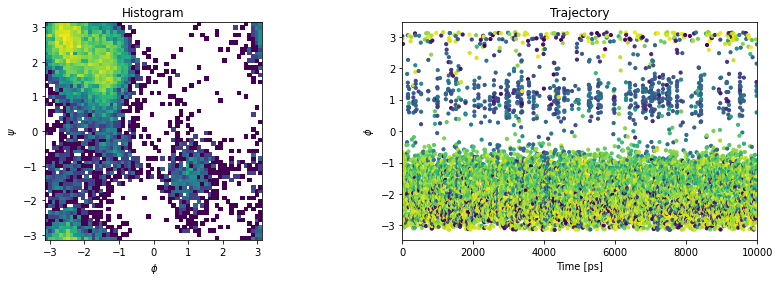

--2022-12-28 10:34:21--  https://raw.githubusercontent.com/invemichele/learned-replica-exchange/main/FESreference/FES-AlanineDipeptideVacuum-T1000.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4716 (4.6K) [text/plain]
Saving to: ‘FES-AlanineDipeptideVacuum-T1000.dat’

FES-AlanineDipeptid 100%[===================>]   4.61K  --.-KB/s    in 0s      

2022-12-28 10:34:21 (61.9 MB/s) - ‘FES-AlanineDipeptideVacuum-T1000.dat’ saved [4716/4716]



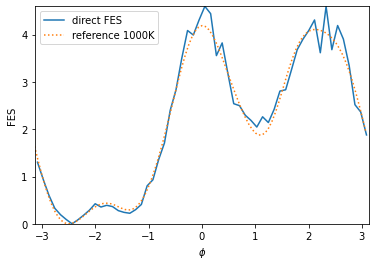

DeltaF at 1000K: 2.211
  DeltaF direct: 2.236

testing data shape: (10_000, 66)


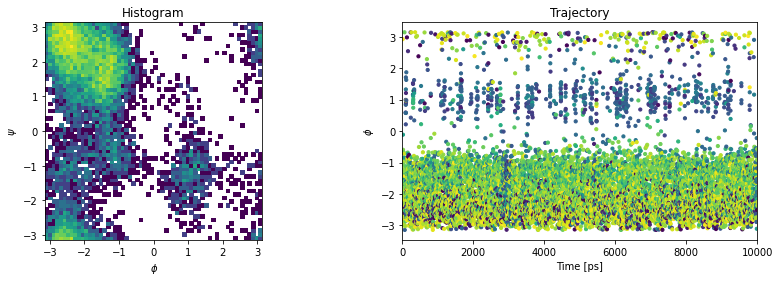

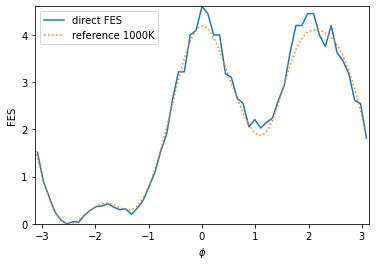

DeltaF at 1000K: 2.211
  DeltaF direct: 2.272

CPU times: user 4min 56s, sys: 18.2 s, total: 5min 14s
Wall time: 5min 22s


In [ ]:
%%time

fraction_training = 2 #MD data is splitted between training and testing
prior_filename = f'MD-{prior_name}-T{T_high}.npz'
try:
    #load MD data if available
    MDdata = np.load(prior_filename)['data']
    MDener = np.load(prior_filename)['ener']
except:
    #otherwise run the simulations
    temp = T_high
    pace = 500
    n_equil = 100
    n_iter = 10_000 * 2 #in the paper this was 20_000 * 2 (and fraction_training=2)
    
    integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1./unit.picosecond, 2.*unit.femtosecond)
    simulation = openmm.app.Simulation(model.topology, model.system, integrator)
    simulation.context.setPositions(model.positions)
    MDdata = np.full((n_iter, *model.positions.shape), np.nan)
    MDener = np.full(n_iter, np.nan)
    
    #equilibrate
    print('equilibrating...')
    simulation.step(pace*n_equil)
    
    #run MD
    for n in range(n_iter):
        simulation.step(pace)
        MDdata[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometer)
        MDener[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
        if (n+1) % (n_iter//20) == 0:
            clear_output(wait=True)
            plot_rama_traj(MDdata)
        # print(f'sampling...  {(n+1)/n_iter:.1%}', end='\r')
    
    np.savez(prior_filename, data=MDdata, ener=MDener)
    clear_output()

#visualize data and move it to torch
len_training = len(MDdata) // fraction_training

print(f'training data shape: ({len_training:_}, {3*len(model.positions)})')
phi = plot_rama_traj(MDdata[:len_training], get_phi=True)
plot_phi_FES(phi)
training_data = torch.tensor(MDdata[:len_training]).view(-1, 3*len(model.positions)).to(**ctx)
training_energies = torch.tensor(MDener[:len_training]/(kB*T_high)).view(-1, 1).to(**ctx)

#test energies for consistency
few = 10
randperm = torch.randperm(len(training_data))
assert torch.allclose(training_energies[randperm][:few], prior.energy(training_data[randperm][:few]))

print(f'\ntesting data shape: ({len(MDdata)-len_training:_}, {3*len(model.positions)})')
phi = plot_rama_traj(MDdata[len_training:], get_phi=True)
plot_phi_FES(phi)
print()
testing_data = torch.tensor(MDdata[len_training:]).view(-1, 3*len(model.positions)).to(**ctx)
testing_energies = torch.tensor(MDener[len_training:]/(kB*T_high)).view(-1, 1).to(**ctx)

del phi, MDdata, MDener

## Build the flow

In [ ]:
z_matrix = bgmol.ZMatrixFactory(model.mdtraj_topology).build_with_templates()[0]
coordinate_transform = bg.GlobalInternalCoordinateTransformation(z_matrix).to(**ctx)

constrained_indices, constrained_lengths = bgmol.bond_constraints(
    model.system, coordinate_transform
)

shape_info = bg.ShapeDictionary.from_coordinate_transform(
    coordinate_transform,
    remove_origin_and_rotation=True,
    n_constraints=len(constrained_indices)
)
shape_info

ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False, is_cartesian=False),
                  (9,)),
                 (TensorInfo(name='ANGLES', is_circular=False, is_cartesian=False),
                  (20,)),
                 (TensorInfo(name='TORSIONS', is_circular=True, is_cartesian=False),
                  (19,))])

In [ ]:
#setup the flow
from bgflow import TORSIONS, BONDS, ANGLES
n_couplings = 2

#head and tail flow, with ic transformation
edge_flow = []
for _ in range(2):
    builder = bg.BoltzmannGeneratorBuilder(shape_info, target, **ctx)
    builder.add_merge_constraints(constrained_indices, constrained_lengths)
    builder.add_map_to_cartesian(coordinate_transform)
    edge_flow.append(builder.build_flow())

# define domain with the assumption that the high temperature has broader domain than the low one
with torch.no_grad():
    # ics_t = coordinate_transform.forward(torch.cat((training_data, testing_data)))
    ics_t = coordinate_transform.forward(training_data)
    domain_kw = []
    for i in range(2):
        delta = ics_t[i].std(axis=0).max().item()
        lower = max(1e-4, ics_t[i].min().item() - delta)
        upper = min(1, ics_t[i].max().item() + delta) #angles cannot be higher than 1, and bonds as well in our case
        domain_kw.append({'left': lower, 'right': upper, 'bottom': lower, 'top': upper})
    del ics_t
    domain_kw = {BONDS: domain_kw[0], ANGLES: domain_kw[1]}

#trainable central flow
builder = bg.BoltzmannGeneratorBuilder(shape_info, target, **ctx)
for _ in range(n_couplings):
    builder.add_condition(TORSIONS, on=(ANGLES, BONDS))
    builder.add_condition(ANGLES, on=(TORSIONS, BONDS), transformer_kwargs=domain_kw[ANGLES])
    builder.add_condition(BONDS, on=(TORSIONS, ANGLES), transformer_kwargs=domain_kw[BONDS])
center_flow = builder.build_flow(zero_parameters=True)

flow = bg.SequentialFlow([bg.InverseFlow(edge_flow[0]), center_flow, edge_flow[1]])
tot_param = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Number of Parameters: {tot_param:_}")

Number of Parameters: 438_842


In [ ]:
#check if the flow is the identity.
few = 100
with torch.no_grad():
    mapped_data, dlogp = flow(training_data[:few])
max_dlogp = dlogp.abs().max().item()
max_delta_rama = np.abs(np.array(get_phi_psi(training_data[:few]))-np.array(get_phi_psi(mapped_data))).max()
flow_is_identity = True if (max_dlogp + max_delta_rama) < 1e-4 else False
print('Max dlogp:', max_dlogp)
print('Max delta phi/psi:', max_delta_rama)
print('Flow is identiy:', flow_is_identity)

Max dlogp: 3.4332275390625e-05
Max delta phi/psi: 8.34465e-07
Flow is identiy: True


### Train the flow

In [ ]:
learning_rate = 1e-3
batch_size = 2**5

optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)
dataloader = torch.utils.data.DataLoader(
    highTempDataset(training_data, training_energies), 
    batch_size=batch_size, shuffle=True
)

#loss function
def KLloss(prior_samples, prior_energies, myflow=flow, mytarget=target):
    mapped_samples, dlogp = myflow(prior_samples)
    return (mytarget.energy(mapped_samples) - dlogp - prior_energies).mean()

reporter = [np.nan]
test_reporter = []
with torch.no_grad():
    if flow_is_identity:
        test_loss = testing_energies.mean().item() * (T_high / T_low - 1)
    else:
        test_loss = KLloss(testing_data, testing_energies).item()
    test_reporter.append(test_loss)
    print(f'Initial KLloss over testing data: {test_loss:g}')

Initial KLloss over testing data: 22.2949


In [ ]:
%%time
#train the flow

n_epochs = 5
test_chunk = 2000

flow_is_identity = False
for epoch in range(n_epochs):
    print(f"Epoch {len(test_reporter)}")
    train_loop(dataloader, KLloss, optimizer, reporter)
    with torch.no_grad():
        rand_chunk = torch.randperm(len(testing_data))[:test_chunk]
        test_loss = KLloss(testing_data[rand_chunk], testing_energies[rand_chunk]).item()
        test_reporter.append(test_loss)
        print(f"\ntest: {test_loss:g}\n-------------------------------")

Epoch 1

test: -0.437215
-------------------------------
Epoch 2

test: -1.47509
-------------------------------
Epoch 3

test: -1.7378
-------------------------------
Epoch 4

test: -1.7652
-------------------------------
Epoch 5

test: -1.86512
-------------------------------
CPU times: user 2min 40s, sys: 1.32 s, total: 2min 41s
Wall time: 2min 52s


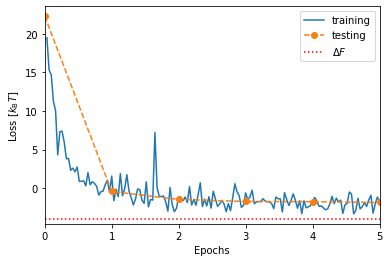

In [ ]:
it = np.arange(len(reporter)) / (len(reporter)-1) * (len(test_reporter)-1)
plt.plot(it, reporter, label='training')
plt.plot(test_reporter, '--o', label='testing')
if DF != 0:
    plt.axhline(DF, c='red', ls='dotted', label='$\Delta F$')
plt.xlim(0, it[-1])
plt.ylabel('Loss [$k_\mathrm{B}T$]')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Visualize trained flow

Final KL distance: 1.97212
Effective sample size: 1151.71
  Sampling efficiency: 1.151708e-01
  Sampling efficiency: 11.52%


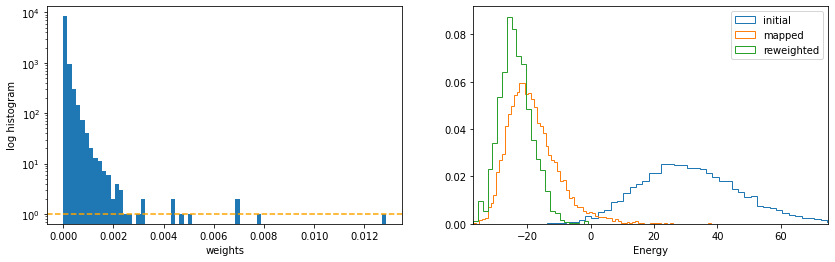

mapped set


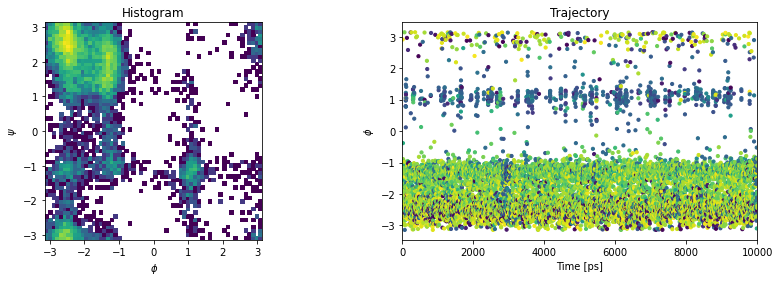

--2022-12-28 10:37:25--  https://raw.githubusercontent.com/invemichele/learned-replica-exchange/main/FESreference/FES-AlanineDipeptideVacuum-T300.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3209 (3.1K) [text/plain]
Saving to: ‘FES-AlanineDipeptideVacuum-T300.dat’

FES-AlanineDipeptid 100%[===================>]   3.13K  --.-KB/s    in 0s      

2022-12-28 10:37:25 (49.6 MB/s) - ‘FES-AlanineDipeptideVacuum-T300.dat’ saved [3209/3209]



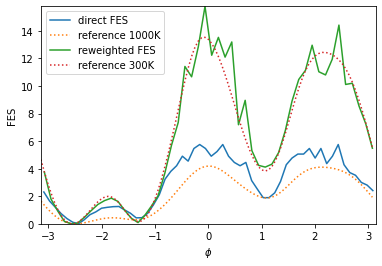

DeltaF at 1000K: 2.211
DeltaF at  300K: 4.650
  DeltaF direct: 2.280
DeltaF reweight: 4.875

CPU times: user 2.28 s, sys: 316 ms, total: 2.6 s
Wall time: 5.15 s


In [ ]:
%%time
#analyze and plot the results
with torch.no_grad():
    samples = testing_data
    samples_ene = testing_energies
    mapped_data, dlogp = flow(samples)
    mapped_ene = target.energy(mapped_data)
    mapped_data = mapped_data.cpu()
    
    logw = (samples_ene + dlogp - mapped_ene).view(-1).cpu()
    print(f'Final KL distance: {- logw.mean().item() - DF:g}')
    logw = logw - torch.logsumexp(logw, dim=-1)
    ESS = bg.effective_sample_size(logw).item()
    print(f'Effective sample size: {ESS:g}')
    print(f'  Sampling efficiency: {ESS/len(logw):e}')
    print(f'  Sampling efficiency: {ESS/len(logw):.2%}')
    
weights = np.exp(assert_numpy(logw))
initial_ene = assert_numpy(samples_ene) * T_high / T_low
mapped_ene = assert_numpy(mapped_ene)
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.hist(weights, bins=75)
plt.xlabel("weights")
plt.ylabel("log histogram")
plt.yscale('log')
plt.axhline(1, linestyle='dashed', c='orange')
plt.subplot(1,2,2)
rangex = np.linspace(min(np.amin(initial_ene), np.amin(mapped_ene)), max(np.percentile(initial_ene, 99), np.percentile(mapped_ene, 90)), 75)
hist_opt = {'density' : True, 'histtype' : 'step', 'bins': 'auto'}
plt.hist(initial_ene, label="initial", **hist_opt)
plt.hist(mapped_ene, label="mapped", **hist_opt)
plt.hist(mapped_ene, label="reweighted", weights=weights, density=True, histtype='step', bins=rangex)
plt.xlabel('Energy')
plt.xlim(rangex[0], rangex[-1])
plt.legend()
plt.show()

print('mapped set')
phi = plot_rama_traj(mapped_data, get_phi=True)
plot_phi_FES(phi, w=weights)
print()

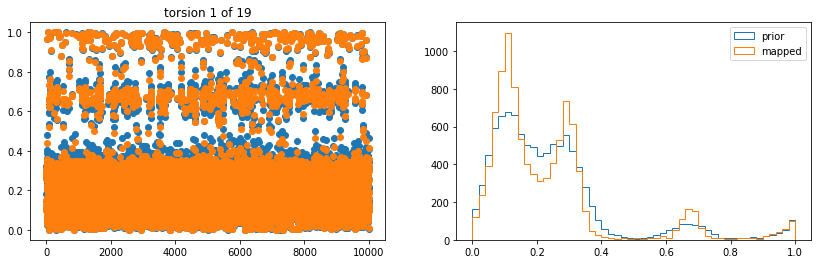

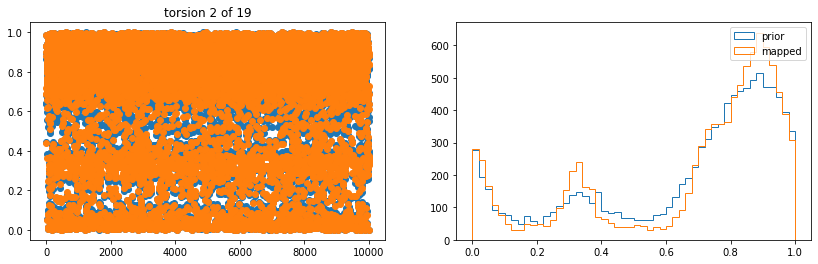

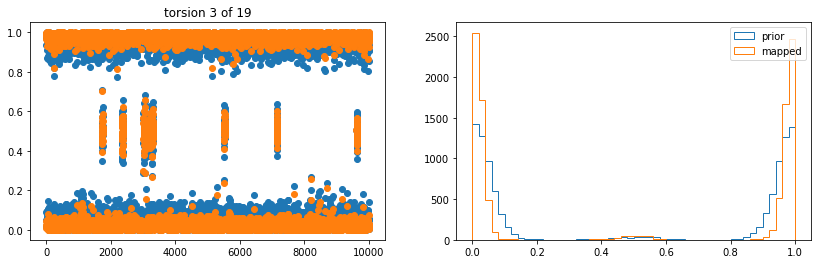

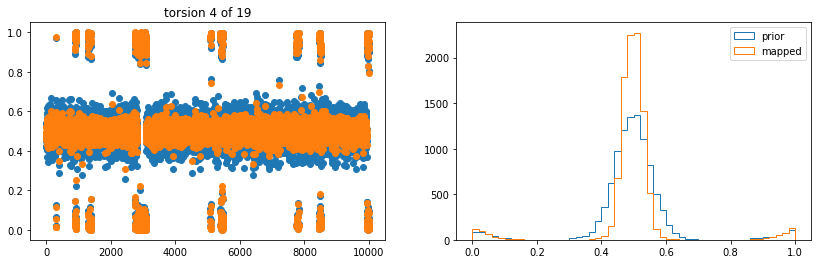

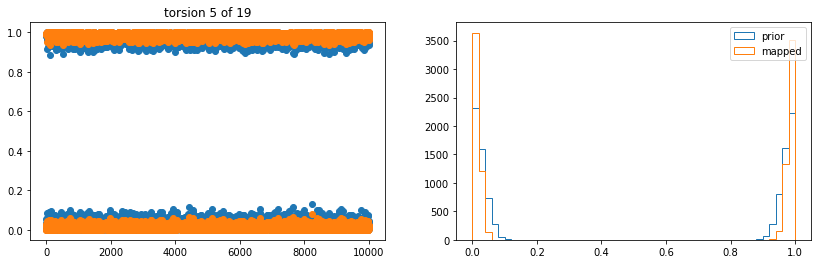

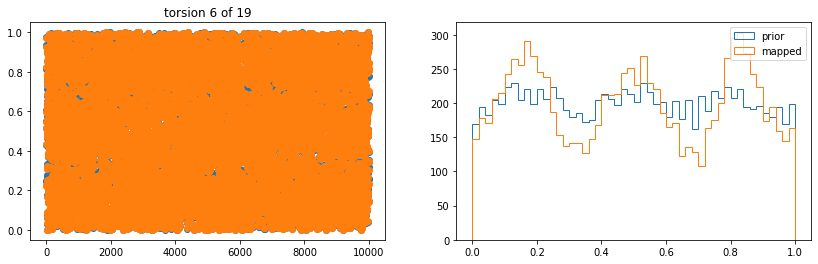

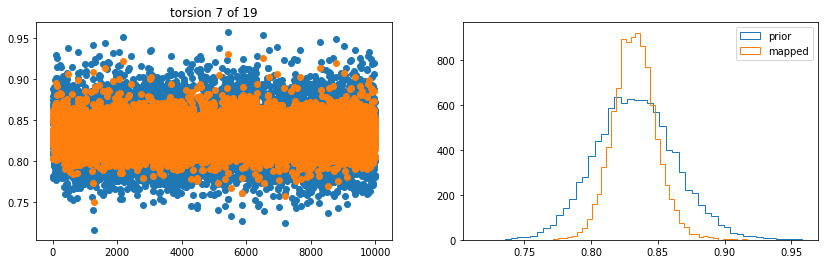

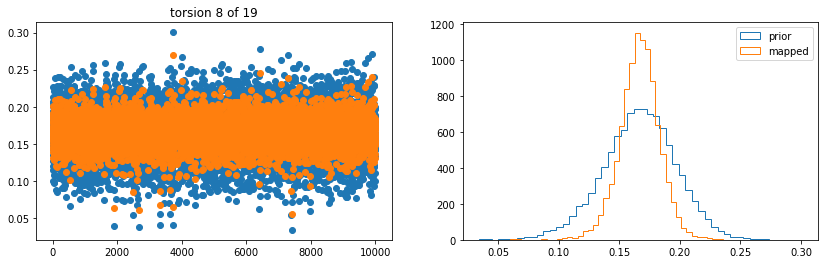

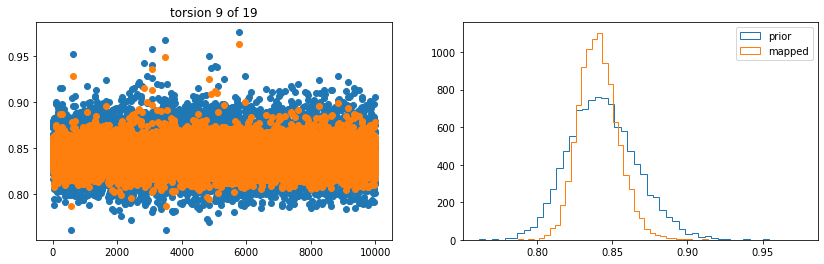

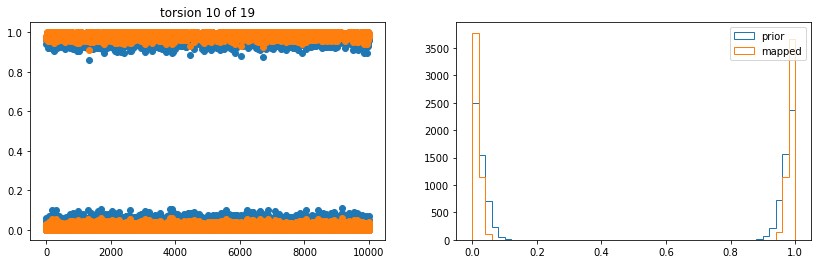

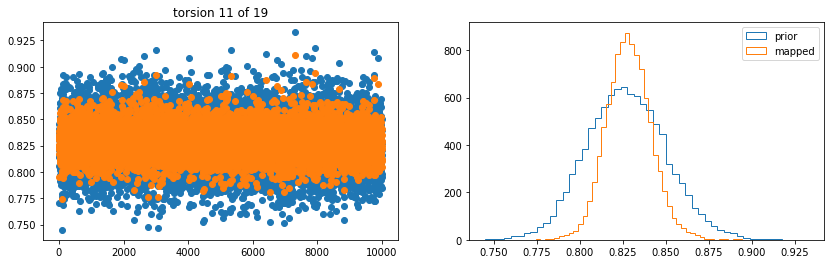

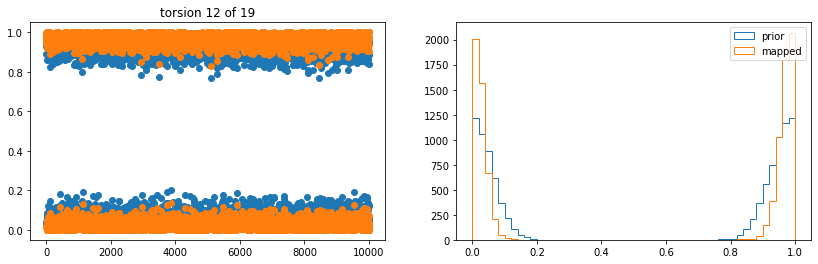

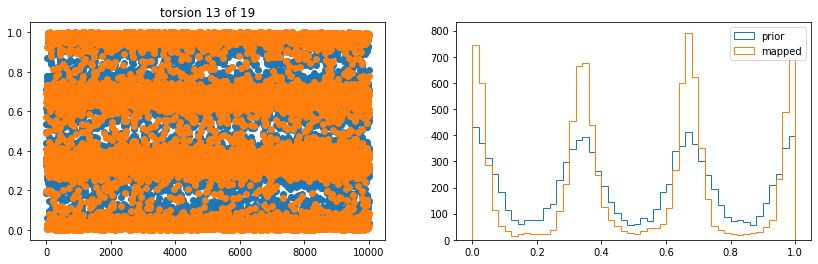

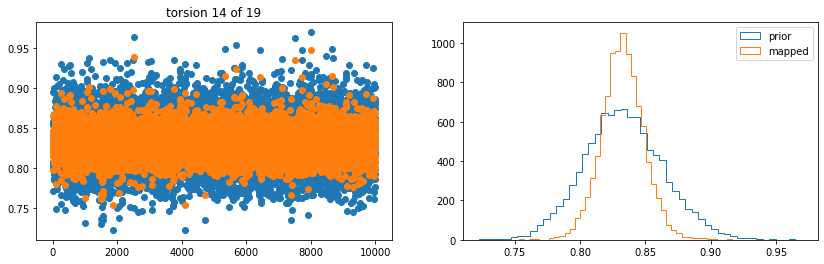

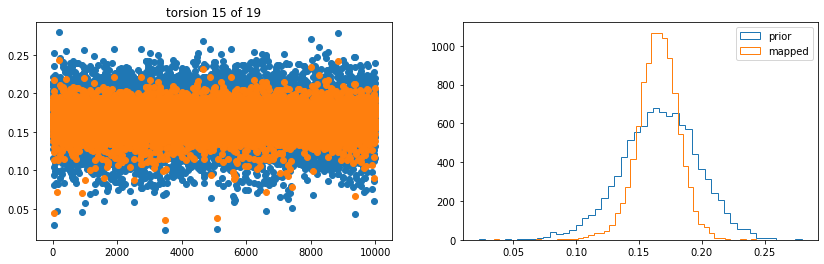

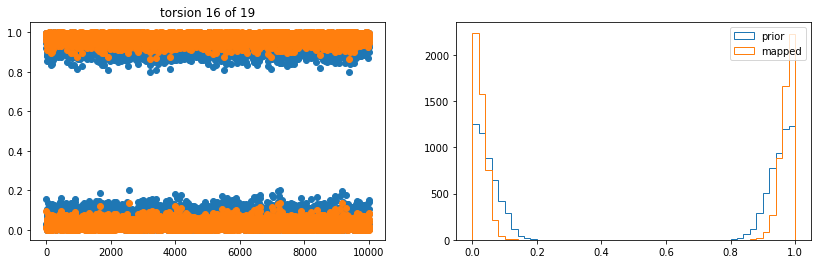

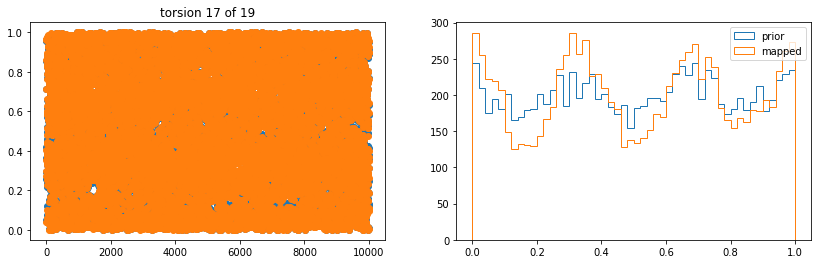

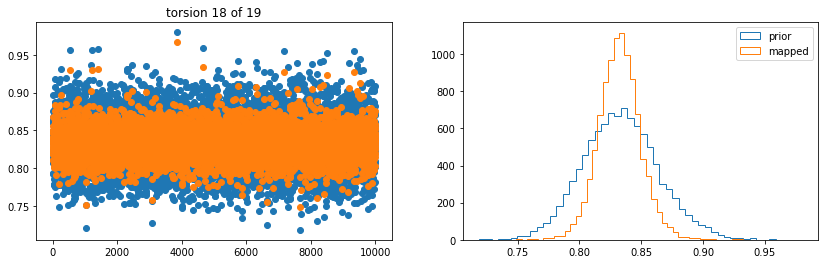

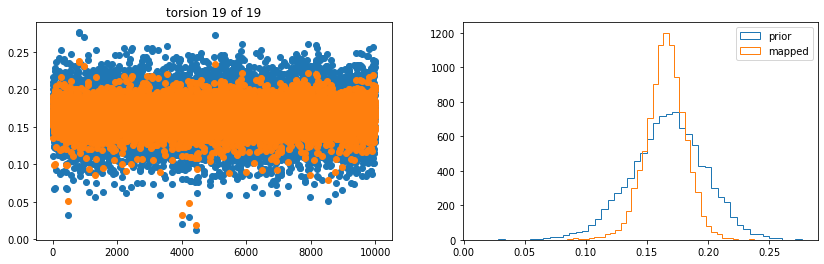

In [ ]:
#plot 1D marginals of internal coordinates
l = 2
title = ['bond', 'angle', 'torsion', 'x0', 'R', 'dlogp']
with torch.no_grad():
    ics_prior = coordinate_transform.forward(testing_data)[l].cpu().numpy()
    ics_mapped = coordinate_transform.forward(mapped_data)[l].cpu().numpy()
for i in range(ics_prior.shape[1]):
    plot_ics(title[l], ics_prior, data2=ics_mapped, chosen=i)

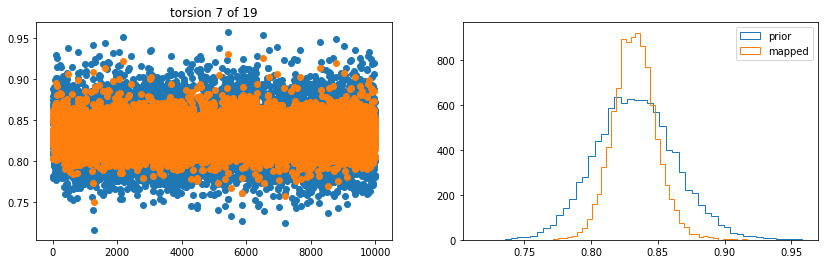

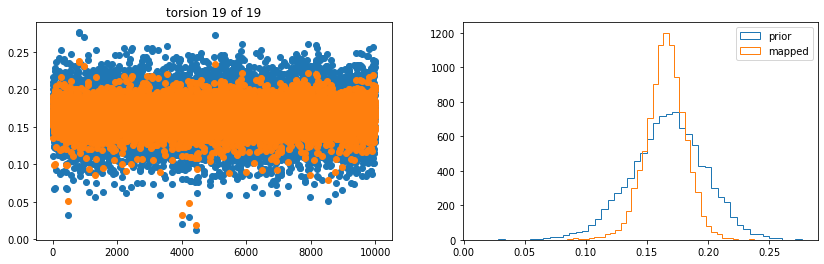

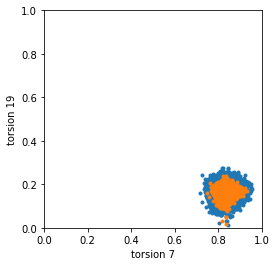

In [ ]:
#Notice that there are also higher dim correlations, not easy to visualize in 1D or 2D
i, j = np.random.randint(ics_prior.shape[1], size=2)
plot_ics(title[l], ics_prior, data2=ics_mapped, chosen=i)
plot_ics(title[l], ics_prior, data2=ics_mapped, chosen=j)

plt.plot(ics_prior[:,i], ics_prior[:,j], '.')
plt.plot(ics_mapped[:,i], ics_mapped[:,j], '.')
plt.gca().set_aspect(1)
plt.xlabel(f'{title[l]} {1+i}')
plt.ylabel(f'{title[l]} {1+j}')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [ ]:
# raise SystemError('Stop here') #next section takes a lot of time

## Run learned replica exchange

For simplicity of implementation, the two replicas do not run in paraller

In [ ]:
%%time

pace = 500
n_iter = 50_000 #in the paper it was 100_000
mc_stride = 1

n_replicas = 2
temperatures = [T_low, T_high]
models = [get_model(target_name, T_low), get_model(prior_name, T_high)]
initial_pos = [model.positions, training_data[-1].view(*model.positions.shape).cpu().numpy()]
integrator = []
simulation = []
for i in range(n_replicas):
    integrator.append(openmm.LangevinMiddleIntegrator(temperatures[i]*unit.kelvin, 1./unit.picosecond, 2.*unit.femtosecond))
    simulation.append(openmm.app.Simulation(models[i].topology, models[i].system, integrator[i]))
    simulation[i].context.setPositions(initial_pos[i])

n_equil = 10
for i in range(n_replicas):
    # print('equilibrating...', i, end='\r')
    simulation[i].step(n_equil*pace)

/usr/local/lib/python3.7/site-packages/bgflow/distribution/energy/openmm.py:204: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  UserWarning


CPU times: user 2.93 s, sys: 0 ns, total: 2.93 s
Wall time: 2.27 s


In [ ]:
%%time

data = np.full((n_replicas, n_iter, *model.positions.shape), np.nan)
mapped_high = np.full((n_iter//mc_stride, *model.positions.shape), np.nan)
logw_high = np.full(n_iter//mc_stride, np.nan)
is_swapped = np.full(n_iter, False)
for n in range(n_iter):
    for i in range(n_replicas):
        simulation[i].step(pace)
        data[i][n] = simulation[i].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometer)
    if n % mc_stride == 0:           
        with torch.no_grad():
            z_h = torch.as_tensor(data[1][n], **ctx).view(1, -1)
            x_h, dlogp_h = flow(z_h, inverse=False)
            logw_h = prior.energy(z_h) + dlogp_h - target.energy(x_h)

            x_l = torch.as_tensor(data[0][n], **ctx).view(1, -1)
            z_l, dlogp_l = flow(x_l, inverse=True)
            logw_l = target.energy(x_l) + dlogp_l - prior.energy(z_l)
        
        mapped_high[n//mc_stride] = x_h.view(*model.positions.shape).cpu().numpy()
        logw_high[n//mc_stride] = logw_h.item()
        
        delta_energy = -(logw_h + logw_l).item()
        if delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy):
            is_swapped[n] = True
            simulation[0].context.setPositions(x_h.view(*model.positions.shape).cpu().numpy())
            simulation[0].context.setVelocitiesToTemperature(temperatures[0])
            simulation[1].context.setPositions(z_l.view(*model.positions.shape).cpu().numpy())
            simulation[1].context.setVelocitiesToTemperature(temperatures[1])
    if (n+1) % (n_iter//100) == 0:
        clear_output(wait=True)
        plot_all_traj(data)#, is_swapped)
    # print(f'sampling...  {(n+1)/n_iter:.1%}, accepted: {is_swapped.sum():g} of {(n+1)//mc_stride} ({mc_stride*is_swapped.sum()/(n+1):.2%})', end='\r')
clear_output(wait=True)

CPU times: user 2h 11min 3s, sys: 2h 34min 40s, total: 4h 45min 43s
Wall time: 3h 50min 27s


### Visualize results

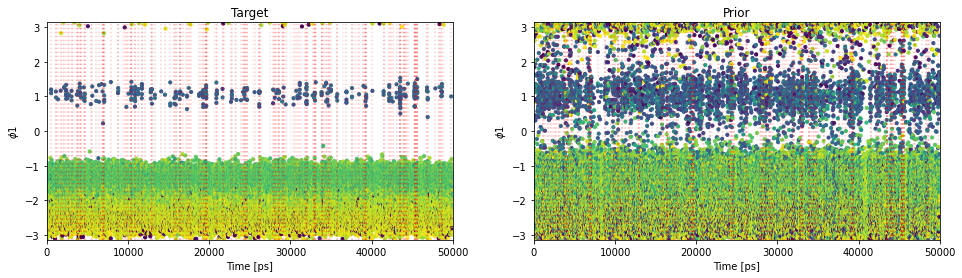

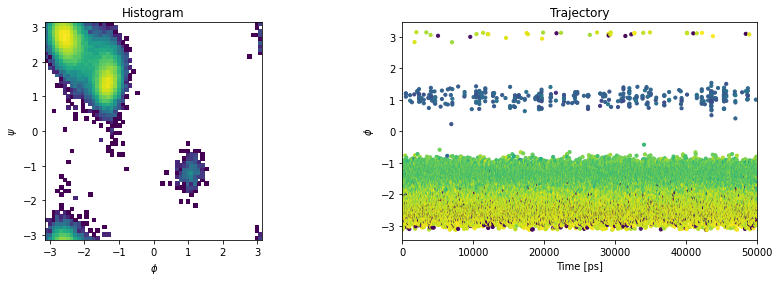

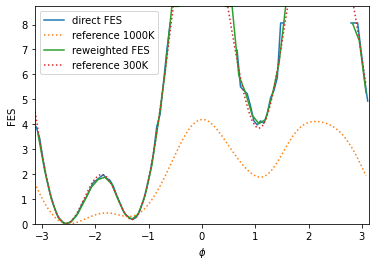

DeltaF at 1000K: 2.211
DeltaF at  300K: 4.650
  DeltaF direct: 4.773
DeltaF reweight: 4.773


In [ ]:
useful_swap = is_swapped * np.array(get_phi_psi(data[0])[0] * get_phi_psi(data[1])[0] < 0) #between different basins
plot_all_traj(data, useful_swap)
phi = plot_rama_traj(data[0], get_phi=True, i=-1)
plot_phi_FES(phi, w=np.ones(len(phi)))

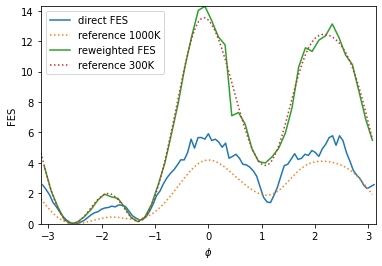

DeltaF at 1000K: 2.211
DeltaF at  300K: 4.650
  DeltaF direct: 2.198
DeltaF reweight: 4.659

ESS: 4665.79
sampling efficiency: 46.66%


In [ ]:
#FES from reweghting
plot_phi_FES(get_phi_psi(mapped_high)[0], w=np.exp(logw_high - np.logaddexp.reduce(logw_high)))
ESS = np.exp(2*np.logaddexp.reduce(logw_high) - np.logaddexp.reduce(2*logw_high))
print(f'\nESS: {ESS:g}')
print(f'sampling efficiency: {ESS/len(logw):.2%}')

Fraction of accepted exchanges: 19.64%
  of which between different states: 3.72%
Fraction of accepted exchanges between different states: 0.73%


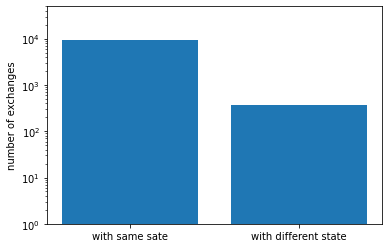

In [ ]:
tot_mc_steps = len(is_swapped)/mc_stride
plt.bar(['with same sate', 'with different state'],[is_swapped.sum()-useful_swap.sum(), useful_swap.sum()])
plt.ylabel('number of exchanges')
plt.yscale('log')
plt.ylim(1, tot_mc_steps)

print(f'Fraction of accepted exchanges: {is_swapped.sum()/tot_mc_steps:.2%}')
print(f'  of which between different states: {useful_swap.sum()/is_swapped.sum():.2%}')
print(f'Fraction of accepted exchanges between different states: {useful_swap.sum()/tot_mc_steps:.2%}')

In [ ]:
filename = f'{system_name}-{prior_name.replace(system_name,"")}{T_high}_{target_name.replace(system_name,"")}{T_low}'
# torch.save(flow, f'{filename}-flow.pt')
np.savez(f'{filename}-traj', T_low=data[0], T_high=data[1], is_swapped=is_swapped)
np.savez(f'{filename}-trajMapped', data=mapped_high, logw=(logw_high - np.logaddexp.reduce(logw_high)))